In [1]:
import time
import numpy as np
import pandas as pd
import random
import torch as t
import copy
from fastcore.foundation import patch
import matplotlib.pyplot as plt

from nixtla.data.tsdataset import TimeSeriesDataset
from nixtla.data.tsloader_general import TimeSeriesLoader as TimeSeriesLoaderGeneral

from nixtla.models.esrnn.esrnn import ESRNN

In [2]:
from nixtla.data.datasets.epf import EPF, EPFInfo
Y_df, X_df = EPF.load(directory='data', group=EPFInfo.groups[0])
train_outsample_mask = np.ones(len(Y_df))
train_outsample_mask[-365 * 24:] = 0
sum(train_outsample_mask)
epf_dataset = TimeSeriesDataset(Y_df=Y_df, S_df=None, X_df=X_df, ts_train_mask=train_outsample_mask)
# print('X: time series features, of shape (#series,#times,#features): \t' + str(X.shape))
# print('Y: target series (in X), of shape (#series,#times): \t \t' + str(Y.shape))
# print('S: static features, of shape (#series,#features): \t \t' + str(S.shape))
Y_df.head()

Processing dataframes ...
Creating ts tensor ...


,unique_id,ds,y
0,NP,2013-01-01 00:00:00,31.05
1,NP,2013-01-01 01:00:00,30.47
2,NP,2013-01-01 02:00:00,28.92
3,NP,2013-01-01 03:00:00,27.88
4,NP,2013-01-01 04:00:00,26.96


In [3]:
train_loader = TimeSeriesLoaderGeneral(ts_dataset=epf_dataset,
                                    model='esrnn',
                                    offset=24,
                                    window_sampling_limit= 90*1*24, #365*4*24
                                    input_size=7*24,
                                    output_size=24,
                                    idx_to_sample_freq=1,
                                    batch_size=1,
                                    is_train_loader=True)

In [4]:
esrnn = ESRNN(input_size=7*24,
              output_size=24,
              max_epochs=5,
              freq_of_test=-1,
              learning_rate=1e-3,
              lr_scheduler_step_size=9,
              lr_decay=0.9,
              per_series_lr_multip=1.0,
              gradient_eps=1e-8,
              gradient_clipping_threshold=20,
              rnn_weight_decay=0,
              noise_std=0.001,
              level_variability_penalty=200,
              testing_percentile=50,
              training_percentile=50,
              cell_type='LSTM',
              state_hsize=40,
              dilations=[[1, 2], [4, 8]],
              add_nl_layer=False,
              seasonality=[24],
              frequency=None,
              max_periods=20,
              random_seed=1,
              device='cpu')

In [5]:
esrnn.fit(train_ts_loader=train_loader, eval_epochs=1)

Infered frequency: H
=============== Training ESRNN  ===============

Epoch: 0, Time: 4.022, Insample loss: 0.14862
Epoch: 1, Time: 8.014, Insample loss: 0.14558
Epoch: 2, Time: 11.924, Insample loss: 0.14277
Epoch: 3, Time: 15.970, Insample loss: 0.14014
Epoch: 4, Time: 20.100, Insample loss: 0.13768


In [6]:
y_hat = esrnn.predict(ts_loader=train_loader)

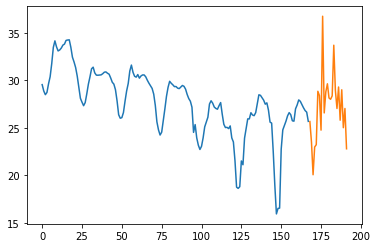

In [7]:
y_plot = Y_df['y'][-168:]
y_hat_plot = y_hat['y_hat']
plt.plot(range(len(y_plot)), y_plot)
plt.plot(range(len(y_plot), len(y_plot)+len(y_hat_plot)), y_hat_plot)

# TOURISM

In [8]:
from nixtla.data.datasets.tourism import Tourism, TourismInfo
group = TourismInfo.groups[0]
print("TourismInfo.groups[0]", group)
Y_df, _ = Tourism.load(directory='data', group=group)
tourism_dataset = TimeSeriesDataset(Y_df=Y_df, S_df=None, X_df=None, ts_train_mask=None)
Y_df['y'] = Y_df['y']+1

TourismInfo.groups[0] Yearly
Processing dataframes ...
Creating ts tensor ...


In [9]:
train_loader = TimeSeriesLoaderGeneral(ts_dataset=tourism_dataset,
                                            model='esrnn',
                                            offset=4,
                                            window_sampling_limit=20*4, 
                                            input_size=1*4,
                                            output_size=4,
                                            idx_to_sample_freq=1,
                                            batch_size= 32,
                                            n_series_per_batch=32,
                                            is_train_loader=True)

In [10]:
esrnn = ESRNN(input_size=1*4,
              output_size=4,
              max_epochs=5,
              freq_of_test=-1,
              learning_rate=1e-3,
              lr_scheduler_step_size=9,
              lr_decay=0.9,
              per_series_lr_multip=1.0,
              gradient_eps=1e-8,
              gradient_clipping_threshold=20,
              rnn_weight_decay=0,
              noise_std=0.001,
              level_variability_penalty=200,
              testing_percentile=50,
              training_percentile=50,
              cell_type='LSTM',
              state_hsize=40,
              dilations=[[1, 2], [4, 8]],
              add_nl_layer=False,
              seasonality=[],
              frequency=None,
              max_periods=20,
              random_seed=1,
              device='cpu')

In [11]:
esrnn.fit(train_ts_loader=train_loader, eval_epochs=1)

Infered frequency: A-DEC
=============== Training ESRNN  ===============

Epoch: 0, Time: 0.252, Insample loss: 5.07064
Epoch: 1, Time: 0.470, Insample loss: 4.94714
Epoch: 2, Time: 0.690, Insample loss: 5.24259
Epoch: 3, Time: 0.907, Insample loss: 4.84759
Epoch: 4, Time: 1.149, Insample loss: 4.86516


In [12]:
y_hat = esrnn.predict(ts_loader=train_loader)

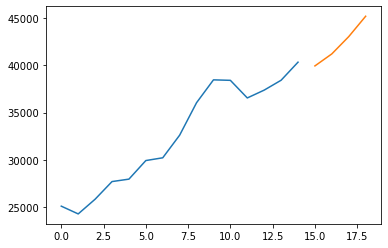

In [13]:
y_plot = Y_df[Y_df['unique_id']=='Y1']['y']
y_hat_plot = y_hat[y_hat['unique_id']=='Y1']['y_hat']
plt.plot(range(len(y_plot)), y_plot)
plt.plot(range(len(y_plot), len(y_plot)+len(y_hat_plot)), y_hat_plot)

In [14]:
y_test = Y_df.groupby('unique_id').tail(4).reset_index(drop=True)
np.mean(np.abs(y_test['y']-y_hat['y_hat'])/np.abs(y_test['y']))

0.19788267442187707